## Preprocess/validate eADAGE network data

In [1]:
import os

import numpy as np
import pandas as pd
import graph_tool.all as gt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# relevant file paths
data_dir = './data'
unprocessed_edge_list = os.path.join(data_dir, 'edgeList.csv')
# TODO: clean up signed vs. unsigned versions of things
# (i.e. make this a script option)
processed_edge_list = os.path.join(data_dir, 'edge_list_processed_unsigned.csv')

# map of Pa gene names to generic/not generic status, generated by Alex
generic_gene_map = os.path.join('..', 'pseudomonas_analysis', 'annot_df.tsv')

# place to save preprocessed graph/attributes, in graph-tool binary format
processed_graph = os.path.join(data_dir, 'eadage_generic_graph_unsigned.gt')

In [3]:
# this is easier to load into graph-tool if we trim to the relevant columns first
if not os.path.isfile(processed_edge_list):
    edgelist_df = pd.read_csv(unprocessed_edge_list, index_col=0)
    # take absolute values of weights
    #
    # most algorithms for community detection/betweenness don't work with
    # negative weights
    # 
    # taking inspiration from WGCNA, we can solve this problem in one 
    # of two ways:
    # unsigned: weight = abs(corr(g1, g2))
    # signed: weight = abs((1 + corr(g1, g2) / 2)
    # 
    # we should probably try both eventually, but for now just use the
    # unsigned version (absolute value of edges). rationale is something
    # like this:
    # https://www.biostars.org/p/144078/#144088
    edgelist_df['weight'] = edgelist_df.weight.abs()
    edgelist_df.to_csv(processed_edge_list, columns=['from', 'to', 'weight'], index=False)

edgelist_df = pd.read_csv(processed_edge_list)
edgelist_df.head()

,from,to,weight
0,PA0001,PA0002,0.578872
1,PA0001,PA0548,0.510323
2,PA0001,PA0963,0.561494
3,PA0001,PA3637,0.512365
4,PA0001,PA5554,0.554768


In [4]:
annot_df = pd.read_csv(generic_gene_map, sep='\t', index_col=0)
annot_df.head()

,label
PA0001,0
PA0002,0
PA0003,0
PA0004,0
PA0005,0


In [5]:
G = gt.load_graph_from_csv(processed_edge_list,
                           skip_first=True,
                           directed=False,
                           hashed=True,
                           eprop_names=['weight'],
                           eprop_types=['float'])

In [6]:
# add vertex property for generic genes
vprop_generic = G.new_vertex_property('bool')
for ix, v in enumerate(G.vertices()):
    v_name = G.vp['name'][v]
    v_label = annot_df.loc[v_name, 'label']
    vprop_generic[v] = v_label

G.vertex_properties['generic'] = vprop_generic

In [7]:
# make sure vertex/edge properties exist
print(G)
print(list(G.vp.keys()))
print(list(G.ep.keys()))

<Graph object, undirected, with 3477 vertices and 31556 edges, 2 internal vertex properties, 1 internal edge property, at 0x7fee6ebf0880>
['name', 'generic']
['weight']


In [8]:
# make sure names/weights from file were loaded properly
for s, t, w in G.iter_edges([G.ep['weight']]):
    print(G.vp['name'][s], G.vp['name'][t], w)
    if s > 0: break

PA0001 PA0002 0.578871792667748
PA0001 PA0548 0.510322953238081
PA0001 PA0963 0.561494130101994
PA0001 PA3637 0.512364523924246
PA0001 PA5554 0.554767556277657
PA0001 PA5556 0.510077492096518
PA0001 PA5557 0.560133539838743
PA0001 PA5560 0.577121244257997
PA0002 PA0004 0.550410666782419


In [9]:
# save graph with attributes to file
G.save(processed_graph, fmt='gt')

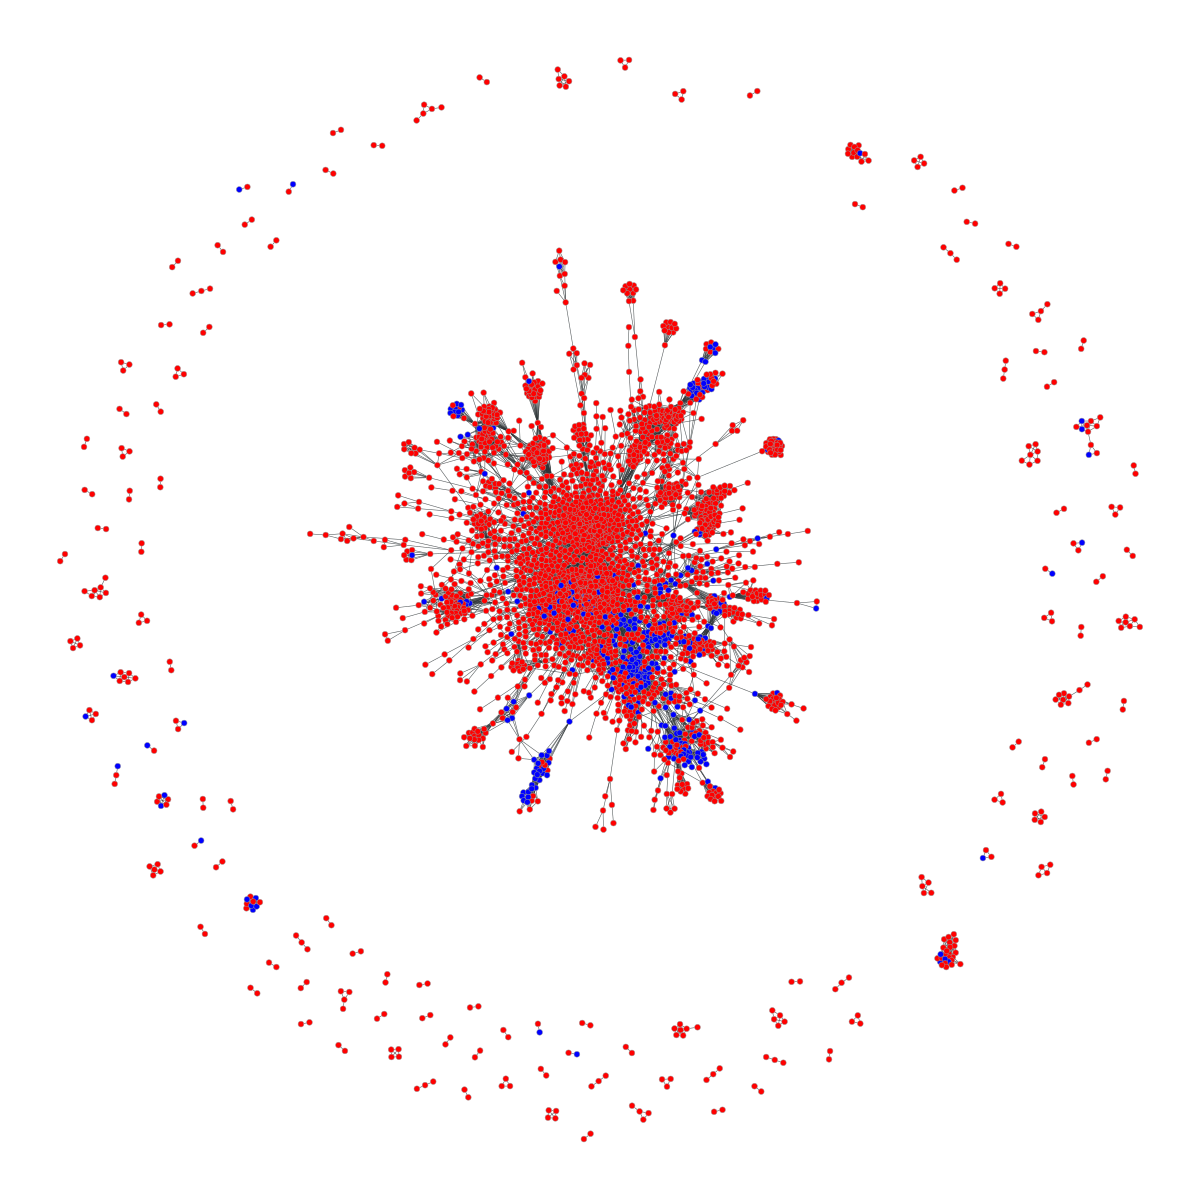

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fee6ebf0880, at 0x7feecc570430>

In [10]:
# plot generic and non-generic genes
# https://stackoverflow.com/a/60462353
red_blue_map = {0: (1, 0, 0, 1), 1: (0, 0, 1, 1)}
plot_color = G.new_vertex_property('vector<double>')
for v in G.vertices():
    plot_color[v] = red_blue_map[G.vp['generic'][v]]
gt.graph_draw(G, vertex_fill_color=plot_color)

In [11]:
# plot degree distribution + look at degrees of generic genes
vs = G.get_vertices()
names = [G.vp['name'][v] for v in vs]
is_generic = [G.vp['generic'][v] for v in vs]
degrees = G.get_total_degrees(vs)
degree_df = pd.DataFrame({
    'gene': names,
    'degree': degrees,
    'is_generic': is_generic
})
degree_df.sort_values(by='degree', ascending=False).head()

,gene,degree,is_generic
26,PA4238,209,0
29,PA4245,201,0
30,PA4247,192,0
79,PA4252,181,0
27,PA4239,180,0


Text(0.5, 1.0, 'Degree distribution of generic/non-generic genes')

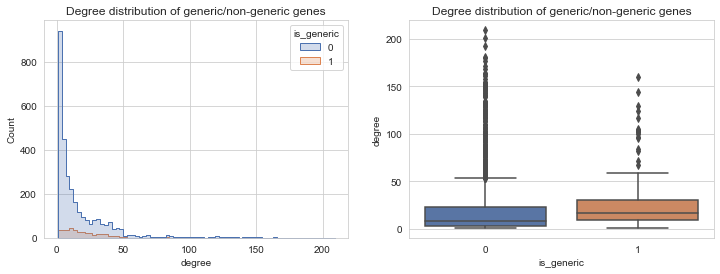

In [12]:
sns.set({'figure.figsize': (12, 4)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 2)
sns.histplot(data=degree_df, x='degree', hue='is_generic', element='step', ax=axarr[0])
axarr[0].set_title('Degree distribution of generic/non-generic genes')
sns.boxplot(data=degree_df, y='degree', x='is_generic', ax=axarr[1])
axarr[1].set_title('Degree distribution of generic/non-generic genes')
# axarr[1].set_yscale('log')

In [13]:
# plot weight distribution + look at weights of edges including generic genes
# (v1, v2, weight, is_generic)
edges = []
for s, t, w in G.iter_edges([G.ep['weight']]):
    if (G.vp['generic'][s]) and (G.vp['generic'][t]):
        is_generic = 2
    elif (G.vp['generic'][s]) or (G.vp['generic'][t]):
        is_generic = 1
    else:
        is_generic = 0
    edges.append((G.vp['name'][s], G.vp['name'][t], w, is_generic))
weight_df = pd.DataFrame(edges, columns=['g1', 'g2', 'weight', 'is_generic'])
print(weight_df.shape)
weight_df.head()

(31556, 4)


,g1,g2,weight,is_generic
0,PA0001,PA0002,0.578872,0
1,PA0001,PA0548,0.510323,0
2,PA0001,PA0963,0.561494,0
3,PA0001,PA3637,0.512365,0
4,PA0001,PA5554,0.554768,1


Text(0.5, 1.0, 'Weight distribution of generic/non-generic edges')

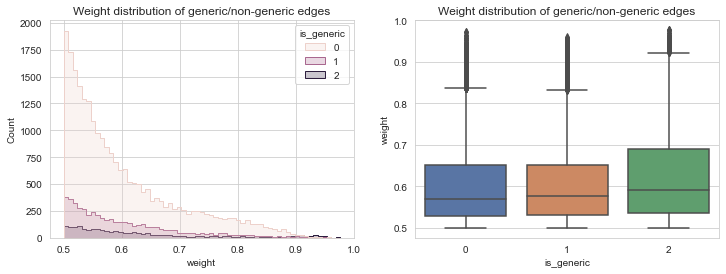

In [14]:
sns.set({'figure.figsize': (12, 4)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 2)
sns.histplot(data=weight_df, x='weight', hue='is_generic', element='step', ax=axarr[0])
axarr[0].set_title('Weight distribution of generic/non-generic edges')
sns.boxplot(data=weight_df, y='weight', x='is_generic', ax=axarr[1])
axarr[1].set_title('Weight distribution of generic/non-generic edges')